In [1]:
import tensorflow as tf
import tensorflow.keras as k
import tensorflow.keras.layers as l

### ResNet18 has only v1 architecture. v1.5 and v2 pattern does not make sense.

## Writing ResNet18 architecture

![resnet18 architecture](../img/resnet18.PNG)

In [4]:
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False, use_bias=False, name=None):
    """
    A residual block as described in the paper "Deep Residual Learning for Image Recognition"
    conv_shortcut: use convolutional shortcut if True, identity shortcut if False
    """
    
    # assuming image_data_format() is "channels_last" i.e. batch_size, h, w, c
    bn_axis = 3
    
    if conv_shortcut:
        shortcut = l.Conv2D(filters, 1, strides=stride, use_bias=use_bias, name=name + "conv0")(x)
        shortcut = l.BatchNormalization(axis=bn_axis, name=name + 'bn0')(shortcut)
    else:
        shortcut = x

    x = l.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=use_bias, name=name + "conv1")(x)
    x = l.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + "bn1")(x)
    x = l.Activation("relu", name=name + "relu1")(x)

    x = l.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=use_bias, name=name + "conv2")(x)
    x = l.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + "bn2")(x)
    
    x = l.Add(name=name + "add")([shortcut, x])
    x = l.Activation("relu", name=name + "relu2_out")(x)
    return x

def ResNet18(input_shape=(224, 224, 3), classes=1000):
    X_input = l.Input(shape=input_shape)
    X = l.ZeroPadding2D(padding=3, name="conv1_pad")(X_input)
    X = l.Conv2D(64, 7, strides=2, name='conv1')(X)
    X = l.BatchNormalization(axis=3, name='conv1_bn')(X)
    X = l.Activation('relu',name='conv1_relu')(X)
    X = l.ZeroPadding2D(padding=1, name="pool1_pad")(X)
    X = l.MaxPooling2D(3, strides=2, name='poo11')(X)

    X = residual_block(X, filters=64, stride=1, conv_shortcut=False, name='g1_b1_conv_shortcut/')
    X = residual_block(X, filters=64, stride=1, conv_shortcut=False, name='g1_b2_id_shortcut/')

    X = residual_block(X, filters=128, stride=2, conv_shortcut=True, name='g2_b1_conv_shortcut/')
    X = residual_block(X, filters=128, stride=1, conv_shortcut=False, name='g2_b2_id_shortcut/')

    X = residual_block(X, filters=256, stride=2, conv_shortcut=True, name='g3_b1_conv_shortcut/')
    X = residual_block(X, filters=256, stride=1, conv_shortcut=False, name='g3_b2_id_shortcut/')

    X = residual_block(X, filters=512, stride=2, conv_shortcut=True, name='g4_b1_conv_shortcut/')
    X = residual_block(X, filters=512, stride=1, conv_shortcut=False, name='g4_b2_id_shortcut/')

    X = l.GlobalAveragePooling2D()(X)
    X = l.Dense(classes, activation='softmax', name='fc' + str(classes))(X)
    model = k.models.Model(inputs=X_input, outputs=X, name='ResNet18')

    return model

In [5]:
model = ResNet18(input_shape=(224, 224, 3), classes=1000)
model.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

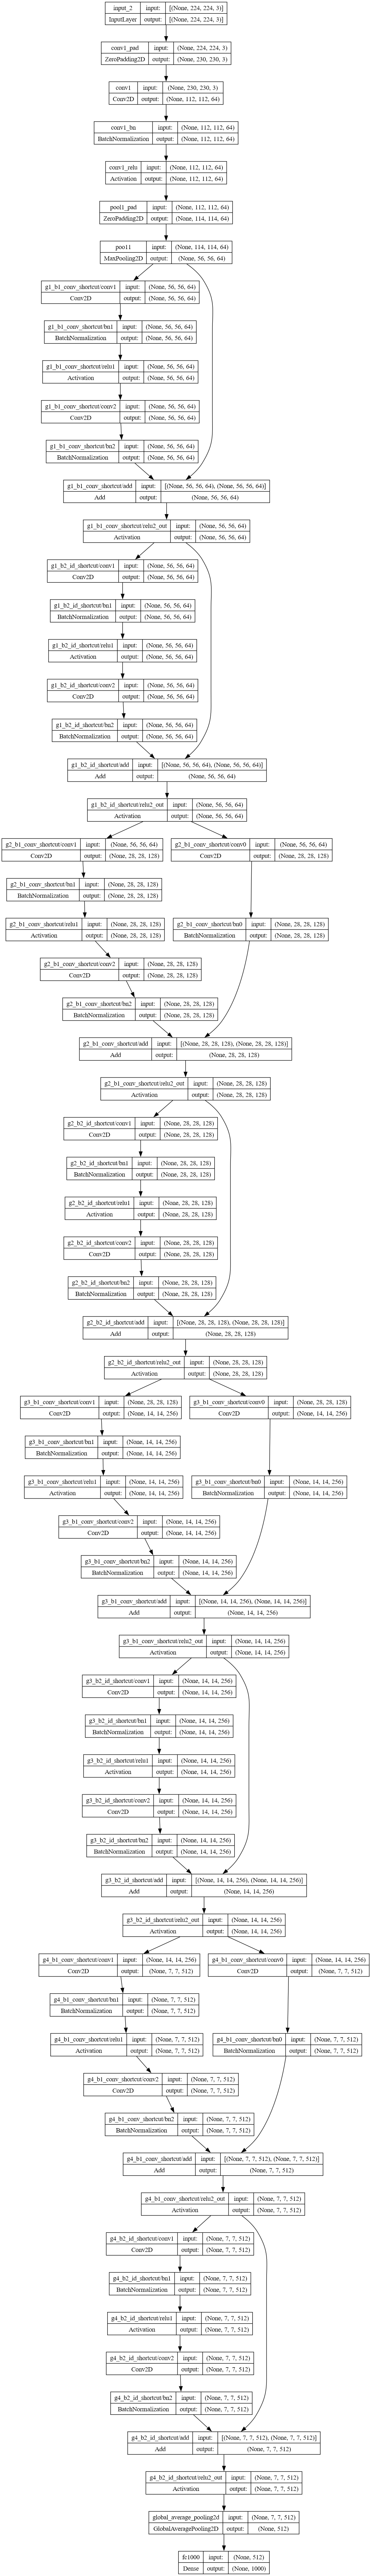

In [6]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)